## Akuisisi Data

In [ ]:
# DATA BISA DIAKUISISI DENGAN MENGGUNAKAN KAGGLE API ATAU 
# MENGUNDUH MANUAL DARI HALAMAN KAGGLE:
# https://www.kaggle.com/datasets/kapillondhe/american-sign-language

# UNZIP DATASET LALU LETAKKAN DATASET DI DIREKTORI YANG SAMA
# DENGAN FILE INI

In [ ]:
# JIKA TIDAK INGIN MENDOWNLOAD DATASET,
# LINK MODEL DAN DATA SIAP TRAIN TERSEDIA DI instruksi.txt

## Import Library

In [1]:
import os
import cv2
import mediapipe as mp
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


## Init Awal

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
TRAIN_DIR = 'ASL_Dataset/Train'
TEST_DIR  = 'ASL_Dataset/Test'

## Function Ekstrak Keypoints

In [5]:
from tqdm import tqdm  # progress bar

def extract_landmarks_with_progress(data_dir, hands):
    """
    Ekstrak landmark Mediapipe dari semua gambar di folder dataset

    :param data_dir: folder dataset (Train atau Test)
    :param hands: instance mp_hands.Hands
    :return: np.array(data), np.array(labels)
    """
    data = []
    labels = []

    labels_list = sorted([l for l in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, l))])
    total_images = sum(len(os.listdir(os.path.join(data_dir, l))) for l in labels_list)
    print(f"Total labels: {len(labels_list)}, Total images: {total_images}\n")

    image_count = 0

    for label in labels_list:
        label_path = os.path.join(data_dir, label)
        img_files = os.listdir(label_path)
        print(f"Processing label '{label}' with {len(img_files)} images...")

        for img_name in tqdm(img_files, desc=f"{label}", unit="img"):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    data_aux = []
                    for lm in hand_landmarks.landmark:
                        data_aux.extend([lm.x, lm.y])

                    # ===== data asli (tangan kanan) =====
                    data.append(data_aux)
                    labels.append(label)
                    
                    # ===== augmentasi tangan kiri (mirror) =====
                    data_aux_mirror = []
                    for i in range(0, len(data_aux), 2):
                        x = data_aux[i]
                        y = data_aux[i+1]
                        data_aux_mirror.extend([1 - x, y])

                    data.append(data_aux_mirror)
                    labels.append(label)

            image_count += 1

    print(f"\nExtraction completed. Total images processed: {image_count}")
    return np.array(data), np.array(labels)


## Visualisasi Awal

C:\Users\praha\AppData\Local\Temp\ipykernel_18884\426842923.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4))


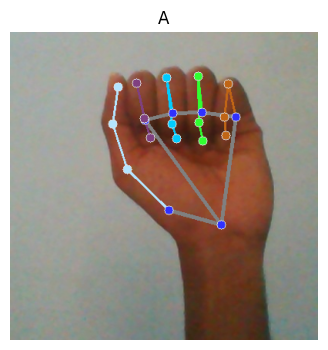

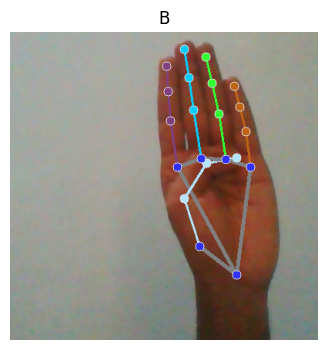

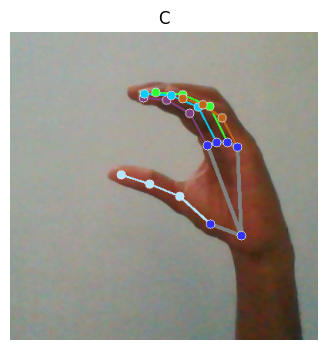

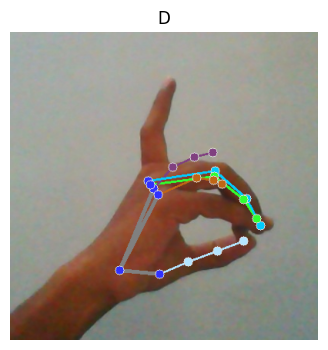

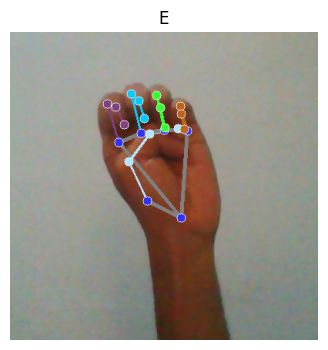

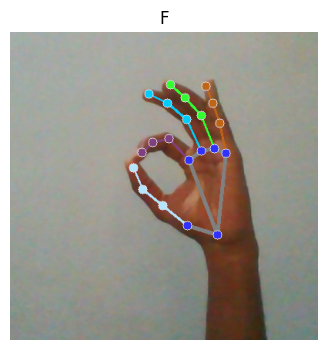

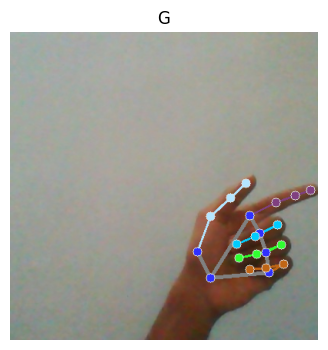

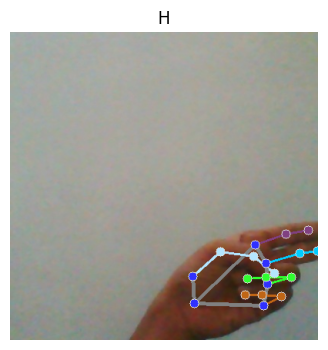

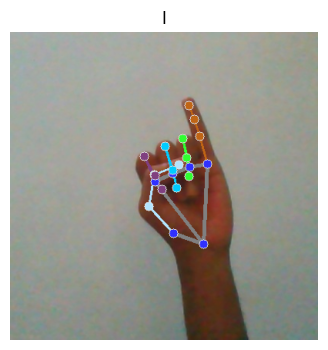

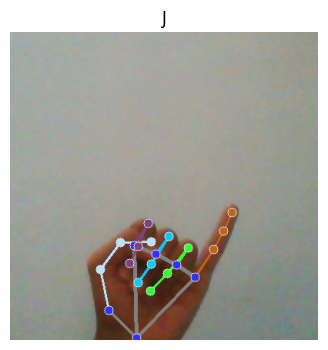

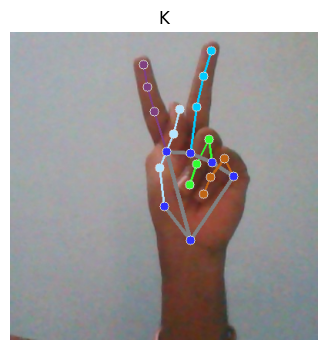

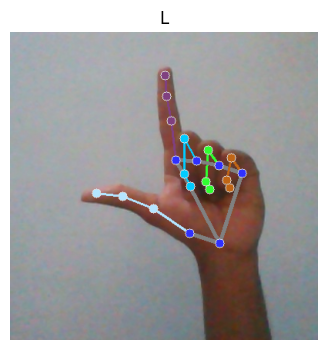

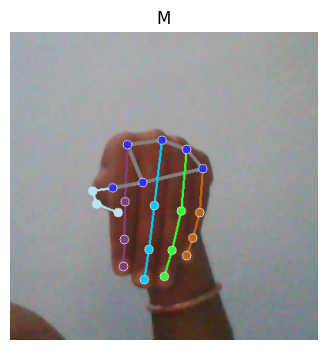

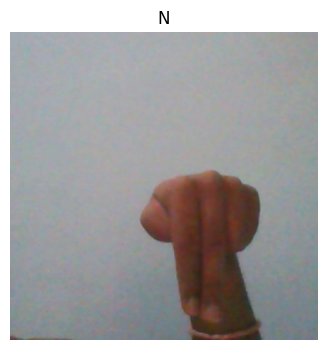

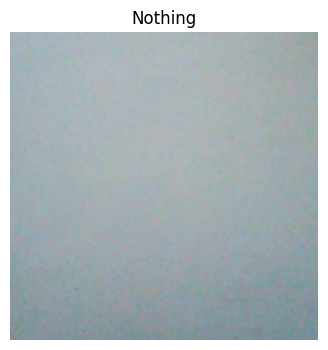

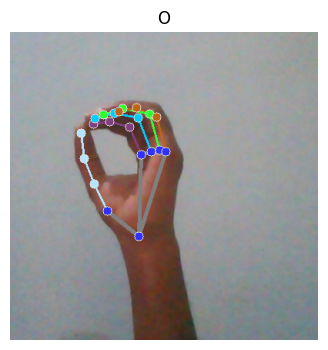

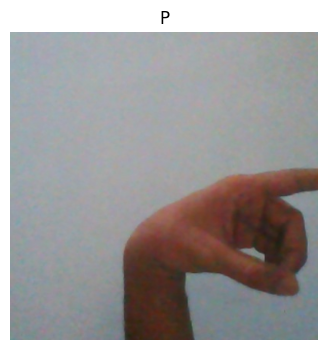

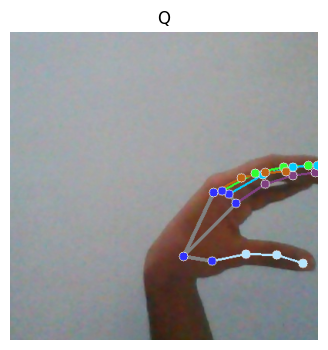

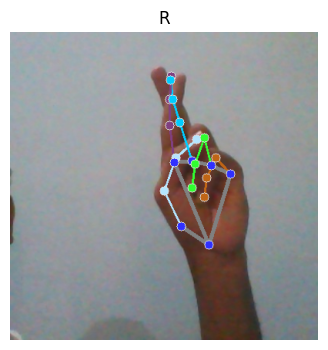

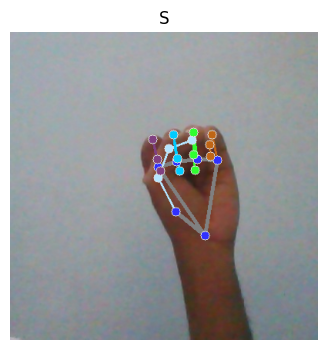

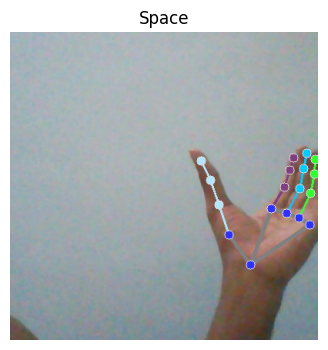

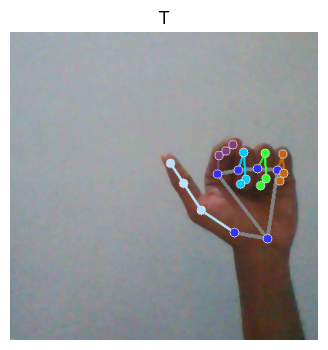

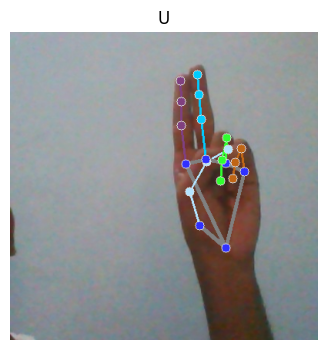

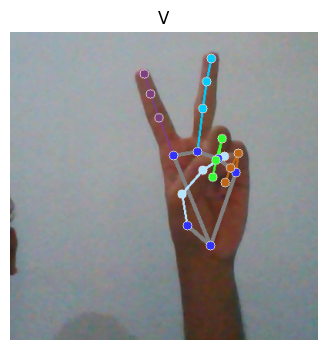

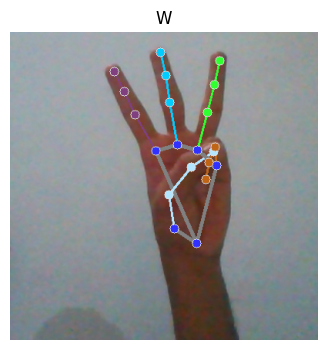

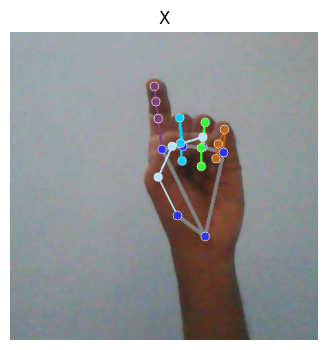

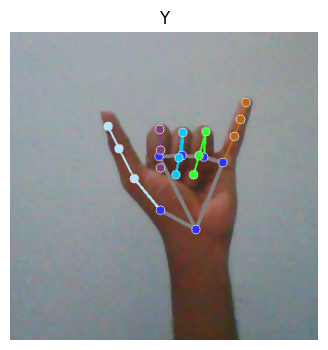

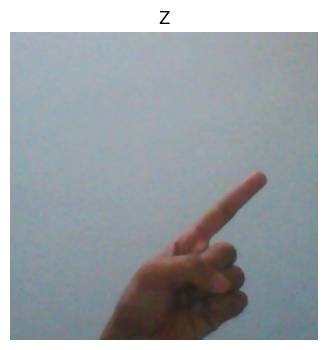

In [14]:
import os
import matplotlib.pyplot as plt


TRAIN_DIR = 'ASL_Dataset/Train'

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
) as hands:

    for label in sorted(os.listdir(TRAIN_DIR)):
        label_path = os.path.join(TRAIN_DIR, label)

        if not os.path.isdir(label_path):
            continue

        # ambil 1 gambar saja per kelas
        img_files = os.listdir(label_path)
        if len(img_files) == 0:
            continue

        img_path = os.path.join(label_path, img_files[0])
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )

        plt.figure(figsize=(4, 4))
        plt.title(label)
        plt.imshow(img_rgb)
        plt.axis('off')

plt.show()


## Preprocessing

Ekstraksi Landmark -> vektor fitur & label -> siap training

In [6]:
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.9
) as hands:
    X_train, y_train = extract_landmarks_with_progress(TRAIN_DIR, hands)


Total labels: 28, Total images: 165670

Processing label 'A' with 5996 images...


A:   0%|          | 0/5996 [00:00<?, ?img/s]c:\Users\praha\Documents\AMK KECERDASAN BUATAN LANJUT\alphabet level sign language 2\mp_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
A: 100%|██████████| 5996/5996 [05:12<00:00, 19.17img/s]


Processing label 'B' with 5996 images...


B: 100%|██████████| 5996/5996 [05:12<00:00, 19.20img/s]


Processing label 'C' with 5996 images...


C: 100%|██████████| 5996/5996 [04:36<00:00, 21.72img/s]


Processing label 'D' with 5996 images...


D: 100%|██████████| 5996/5996 [03:28<00:00, 28.80img/s]


Processing label 'E' with 5996 images...


E: 100%|██████████| 5996/5996 [05:12<00:00, 19.19img/s]


Processing label 'F' with 5996 images...


F: 100%|██████████| 5996/5996 [05:19<00:00, 18.77img/s]


Processing label 'G' with 5996 images...


G: 100%|██████████| 5996/5996 [05:23<00:00, 18.53img/s]


Processing label 'H' with 5996 images...


H: 100%|██████████| 5996/5996 [05:11<00:00, 19.24img/s]


Processing label 'I' with 5996 images...


I: 100%|██████████| 5996/5996 [05:07<00:00, 19.49img/s]


Processing label 'J' with 5996 images...


J: 100%|██████████| 5996/5996 [05:11<00:00, 19.24img/s]


Processing label 'K' with 5996 images...


K: 100%|██████████| 5996/5996 [05:11<00:00, 19.28img/s]


Processing label 'L' with 5996 images...


L: 100%|██████████| 5996/5996 [04:46<00:00, 20.94img/s]


Processing label 'M' with 5996 images...


M: 100%|██████████| 5996/5996 [03:49<00:00, 26.08img/s]


Processing label 'N' with 5996 images...


N: 100%|██████████| 5996/5996 [03:07<00:00, 31.93img/s]


Processing label 'Nothing' with 5996 images...


Nothing: 100%|██████████| 5996/5996 [02:54<00:00, 34.32img/s]


Processing label 'O' with 5996 images...


O: 100%|██████████| 5996/5996 [04:23<00:00, 22.74img/s]


Processing label 'P' with 5996 images...


P: 100%|██████████| 5996/5996 [04:19<00:00, 23.09img/s]


Processing label 'Q' with 5996 images...


Q: 100%|██████████| 5996/5996 [04:10<00:00, 23.94img/s]


Processing label 'R' with 5966 images...


R: 100%|██████████| 5966/5966 [05:21<00:00, 18.54img/s]


Processing label 'S' with 5996 images...


S: 100%|██████████| 5996/5996 [04:52<00:00, 20.47img/s]


Processing label 'Space' with 5886 images...


Space: 100%|██████████| 5886/5886 [03:38<00:00, 26.95img/s]


Processing label 'T' with 5648 images...


T: 100%|██████████| 5648/5648 [04:47<00:00, 19.67img/s]


Processing label 'U' with 4542 images...


U: 100%|██████████| 4542/4542 [03:58<00:00, 19.03img/s]


Processing label 'V' with 5996 images...


V: 100%|██████████| 5996/5996 [05:06<00:00, 19.58img/s]


Processing label 'W' with 5996 images...


W: 100%|██████████| 5996/5996 [05:08<00:00, 19.42img/s]


Processing label 'X' with 5996 images...


X: 100%|██████████| 5996/5996 [05:07<00:00, 19.48img/s]


Processing label 'Y' with 5720 images...


Y: 100%|██████████| 5720/5720 [05:07<00:00, 18.62img/s]


Processing label 'Z' with 5996 images...


Z: 100%|██████████| 5996/5996 [04:23<00:00, 22.75img/s]



Extraction completed. Total images processed: 165670


In [8]:
print("Jumlah sampel data:", X_train.shape[0])
print("Jumlah label:", y_train.shape[0])

Jumlah sampel data: 249146
Jumlah label: 249146


In [14]:
with mp_hands.Hands( 
    static_image_mode=True, 
    max_num_hands=1, 
    min_detection_confidence=0.9 
) as hands:
    X_test, y_test = extract_landmarks_with_progress(TEST_DIR, hands)

Total labels: 28, Total images: 112

Processing label 'A' with 4 images...


A: 100%|██████████| 4/4 [00:00<00:00, 15.82img/s]


Processing label 'B' with 4 images...


B: 100%|██████████| 4/4 [00:00<00:00, 18.32img/s]


Processing label 'C' with 4 images...


C: 100%|██████████| 4/4 [00:00<00:00, 18.51img/s]


Processing label 'D' with 4 images...


D: 100%|██████████| 4/4 [00:00<00:00, 28.17img/s]


Processing label 'E' with 4 images...


E: 100%|██████████| 4/4 [00:00<00:00, 18.41img/s]


Processing label 'F' with 4 images...


F: 100%|██████████| 4/4 [00:00<00:00, 18.52img/s]


Processing label 'G' with 4 images...


G: 100%|██████████| 4/4 [00:00<00:00, 18.74img/s]


Processing label 'H' with 4 images...


H: 100%|██████████| 4/4 [00:00<00:00, 17.48img/s]


Processing label 'I' with 4 images...


I: 100%|██████████| 4/4 [00:00<00:00, 17.80img/s]


Processing label 'J' with 4 images...


J: 100%|██████████| 4/4 [00:00<00:00, 17.66img/s]


Processing label 'K' with 4 images...


K: 100%|██████████| 4/4 [00:00<00:00, 18.27img/s]


Processing label 'L' with 4 images...


L: 100%|██████████| 4/4 [00:00<00:00, 18.58img/s]


Processing label 'M' with 4 images...


M: 100%|██████████| 4/4 [00:00<00:00, 18.74img/s]


Processing label 'N' with 4 images...


N: 100%|██████████| 4/4 [00:00<00:00, 31.27img/s]


Processing label 'Nothing' with 4 images...


Nothing: 100%|██████████| 4/4 [00:00<00:00, 34.25img/s]


Processing label 'O' with 4 images...


O: 100%|██████████| 4/4 [00:00<00:00, 33.94img/s]


Processing label 'P' with 4 images...


P: 100%|██████████| 4/4 [00:00<00:00, 34.66img/s]


Processing label 'Q' with 4 images...


Q: 100%|██████████| 4/4 [00:00<00:00, 34.82img/s]


Processing label 'R' with 4 images...


R: 100%|██████████| 4/4 [00:00<00:00, 18.16img/s]


Processing label 'S' with 4 images...


S: 100%|██████████| 4/4 [00:00<00:00, 18.01img/s]


Processing label 'Space' with 4 images...


Space: 100%|██████████| 4/4 [00:00<00:00, 28.21img/s]


Processing label 'T' with 4 images...


T: 100%|██████████| 4/4 [00:00<00:00, 18.24img/s]


Processing label 'U' with 4 images...


U: 100%|██████████| 4/4 [00:00<00:00, 18.84img/s]


Processing label 'V' with 4 images...


V: 100%|██████████| 4/4 [00:00<00:00, 18.06img/s]


Processing label 'W' with 4 images...


W: 100%|██████████| 4/4 [00:00<00:00, 18.27img/s]


Processing label 'X' with 4 images...


X: 100%|██████████| 4/4 [00:00<00:00, 18.38img/s]


Processing label 'Y' with 4 images...


Y: 100%|██████████| 4/4 [00:00<00:00, 17.94img/s]


Processing label 'Z' with 4 images...


Z: 100%|██████████| 4/4 [00:00<00:00, 23.76img/s]


Extraction completed. Total images processed: 112


## Simpan hasil ekstraksi

In [9]:
import pickle

# Simpan data train
with open('train_data_aug.pickle', 'wb') as f:
    pickle.dump({'data': X_train, 'labels': y_train}, f)

# Simpan data test
# with open('test_data_aug.pickle', 'wb') as f:
#     pickle.dump({'data': X_test, 'labels': y_test}, f)


## Load data siap training

Data train dan test yang sudah siap di train: https://drive.google.com/drive/folders/1-CYIYzcI2VOMf6ESV_ZW5BKrJ6mu2uZ5?usp=sharing



In [ ]:
## Load data train dan test
# with open('trWain_data.pickle', 'rb') as f:
#     train = pickle.load(f)
# X_train = train['data']
# y_train = train['labels']

# with open('test_data.pickle', 'rb') as f:
#     test = pickle.load(f)
# X_test = test['data']
# y_test = test['labels']

In [10]:
with open('train_data_aug.pickle', 'rb') as f:
    train = pickle.load(f)
X_full = train['data']
y_full = train['labels']

In [11]:
X_full[2]
# X_full[2].shape

array([0.3822673 , 0.79679239, 0.27931181, 0.79202646, 0.19045049,
       0.68908554, 0.16780153, 0.58077723, 0.18092194, 0.5060519 ,
       0.22852434, 0.57342815, 0.23248886, 0.49560833, 0.2441999 ,
       0.58042026, 0.24372447, 0.61401695, 0.29589248, 0.56651694,
       0.29921553, 0.49633902, 0.30396339, 0.59823948, 0.29987219,
       0.61410832, 0.36183158, 0.57091314, 0.36652437, 0.5109055 ,
       0.36635345, 0.60720289, 0.3625046 , 0.62799418, 0.43173921,
       0.58104146, 0.43010336, 0.52725315, 0.42692757, 0.59653574,
       0.42508262, 0.6232971 ])

In [12]:
y_full[2]

'A'

## Training Model - Arsitektur MLP

Encoding

In [13]:
# Encode label ke one-hot
le = LabelEncoder()
y_full_enc = to_categorical(le.fit_transform(y_full))

In [14]:
# Simpan label encoder
with open('label_encoder_aug.pickle', 'wb') as f:
    pickle.dump(le, f)

Split Train/Test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full_enc,
    test_size=0.15,
    random_state=42,
    stratify=y_full_enc.argmax(axis=1)  # jaga proporsi kelas
)

Inisialisasi Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [17]:
input_dim = X_train.shape[1]  # 42 (21 landmark * 2)
n_classes = y_train.shape[1]

In [18]:
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

In [19]:
model_nn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 27)                1755      
                                                                 
Total params: 15515 (60.61 KB)
Trainable params: 15515 (60.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,     # jika val_accuracy tidak naik 3 epoch berturut-turut, stop
    restore_best_weights=True
)

In [22]:
# train the model
history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,       # tetap set max epoch tinggi
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/50


13236/13236 [==============================] - 35s 3ms/step - loss: 0.3657 - accuracy: 0.8770 - val_loss: 0.0286 - val_accuracy: 0.9933
Epoch 2/50
13236/13236 [==============================] - 31s 2ms/step - loss: 0.0757 - accuracy: 0.9735 - val_loss: 0.0153 - val_accuracy: 0.9956
Epoch 3/50
13236/13236 [==============================] - 33s 2ms/step - loss: 0.0542 - accuracy: 0.9814 - val_loss: 0.0070 - val_accuracy: 0.9987
Epoch 4/50
13236/13236 [==============================] - 31s 2ms/step - loss: 0.0420 - accuracy: 0.9858 - val_loss: 0.0142 - val_accuracy: 0.9942
Epoch 5/50
13236/13236 [==============================] - 31s 2ms/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0061 - val_accuracy: 0.9984
Epoch 6/50
13236/13236 [==============================] - 34s 3ms/step - loss: 0.0316 - accuracy: 0.9897 - val_loss: 0.0081 - val_accuracy: 0.9972


Evaluasi

In [23]:
# Eval
loss, acc = model_nn.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

1168/1168 [==============================] - 2s 2ms/step - loss: 0.0070 - accuracy: 0.9987
Test Accuracy: 99.87%


In [24]:

# ground truth & prediksi
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_nn.predict(X_test, verbose=0), axis=1)

print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=le.classes_  
))


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1753
           B       1.00      1.00      1.00      1775
           C       1.00      1.00      1.00      1271
           D       1.00      1.00      1.00       479
           E       1.00      1.00      1.00      1731
           F       1.00      1.00      1.00      1743
           G       1.00      1.00      1.00      1738
           H       1.00      1.00      1.00      1746
           I       1.00      1.00      1.00      1738
           J       1.00      1.00      1.00      1772
           K       1.00      1.00      1.00      1796
           L       1.00      1.00      1.00      1496
           M       1.00      1.00      1.00       742
           N       1.00      0.98      0.99       154
           O       1.00      1.00      1.00      1050
           P       1.00      1.00      1.00       869
           Q       1.00      1.00      1.00       834
    

## Simpan Model

In [25]:
model_nn.save('model_nn_aug.h5')

c:\Users\praha\Documents\AMK KECERDASAN BUATAN LANJUT\alphabet level sign language 2\mp_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Deteksi Realtime

Model yang sudah ditrain beserta label encoder nya:
https://drive.google.com/drive/folders/1bLMTPYfIp5zfRJIPQUcq3ueDLU05xeTU?usp=sharing


In [4]:
# load model untuk prediksi 
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

model_nn = load_model('model_nn_aug.h5')

In [5]:
# load label encoder agar bisa decode prediksi
with open("label_encoder_aug.pickle", "rb") as f:
    le = pickle.load(f)

In [6]:
# run prediksi dummy awal agar model ter-load dengan benar 
# dan graph internal dibangun sebelum dipakai realtime 
dummy_input = np.zeros((1, 42))
model_nn.predict(dummy_input, verbose=0)

array([[3.9156079e-05, 2.2324992e-23, 1.1150609e-09, 1.1150339e-04,
        1.8256544e-15, 3.8931252e-13, 3.0188900e-11, 1.3566099e-03,
        2.9937678e-04, 5.4377411e-04, 1.8191023e-19, 8.4159381e-11,
        4.6495648e-04, 5.6004161e-01, 4.4377857e-09, 4.3223867e-01,
        2.3067549e-05, 4.6791577e-18, 2.4617413e-05, 3.6583061e-09,
        3.6249666e-03, 1.4360135e-17, 1.3529126e-15, 8.1833379e-20,
        4.7775895e-08, 1.2316437e-03, 7.5933544e-11]], dtype=float32)

pencet 'q' untuk keluar

In [18]:
cap = cv2.VideoCapture(0)

frame_count = 0
SKIP_FRAMES = 3  # prediksi tiap 3 frame
last_prediction = ""
last_confidence = 0.0

# confidence threshold untuk unknown gesture
CONF_THRESHOLD = 0.75

# untuk evaluasi akurasi realtime 
# TARGET_LABEL = "A"  
# correct = 0
# total = 0
# PRINT_EVERY = 3     # print setiap n prediksi


# Mediapipe Hands (Mode Realtime)
with mp_hands.Hands(
    min_detection_confidence=0.6,
    min_tracking_confidence=0.9
) as hands:

    while cap.isOpened():
        
        # inisialisasi variabel
        data_aux = [] # menyimpan landmark x dan y sementara
        x_ = [] # menyimpan koordinat x
        y_ = [] # menyimpan koordinat y

        # Baca Frame Webcam
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1 

        H, W, _ = frame.shape # dimensi frame

        # Preprocessing Frame
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.flip(frame_rgb, 1)
        frame_rgb.flags.writeable = False
        results = hands.process(frame_rgb)
        frame_rgb.flags.writeable = True
        frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

        # dijalankan jika tangan terdeteksi
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame_rgb,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(28, 255, 3), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(236, 255, 3), thickness=2, circle_radius=2)
                )
                
                # Ekstraksi Fitur
                for lm in hand_landmarks.landmark:
                    data_aux.extend([lm.x, lm.y])
                    x_.append(lm.x)
                    y_.append(lm.y)

            # bounding box
            margin = 20
            x1 = max(int(min(x_) * W) - margin, 0)
            y1 = max(int(min(y_) * H) - margin, 0)
            x2 = min(int(max(x_) * W) + margin, W)
            y2 = min(int(max(y_) * H) + margin, H)

            # ===== PREDIKSI DENGAN FRAME SKIPPING =====
            # Mengubah landmark menjadi format input model
            data_input = np.array(data_aux)[0:42].reshape(1, -1)

            # Prediksi hanya dilakukan setiap SKIP_FRAMES
            if frame_count % SKIP_FRAMES == 0:
                proba_all = model_nn.predict(data_input, verbose=0)[0]
                class_index = np.argmax(proba_all)
                confidence = proba_all[class_index]
                
                # ===== UNKNOWN GESTURE DETECTION =====
                if confidence < CONF_THRESHOLD:
                    last_prediction = "Unknown"
                    last_confidence = confidence
                else:
                    last_prediction = le.inverse_transform([class_index])[0]
                    last_confidence = confidence
                    
                # # ===== EVALUASI REALTIME =====
                # total += 1

                # if prediction == TARGET_LABEL:
                #     correct += 1

                # # hitung akurasi
                # realtime_accuracy = correct / total

                # # print berkala agar tidak spam
                # if total % PRINT_EVERY == 0:
                #     print(
                #         f"[Realtime Eval] "
                #         f"Target: {TARGET_LABEL} | "
                #         f"Total: {total} | "
                #         f"Correct: {correct} | "
                #         f"Accuracy: {realtime_accuracy:.3f}"
                #     )
                # # ===============================

            prediction = last_prediction
            confidence = last_confidence

            # tampilkan hasil
            cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (255, 99, 173), 4)
            cv2.putText(
                frame_rgb,
                f"{prediction} ({confidence:.2f})",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_DUPLEX,
                1.8,
                (255, 0, 0),
                2,
                cv2.LINE_AA
            )

        cv2.imshow("frame", frame_rgb)
        # keluar dngan menekan 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# print("Realtime Accuracy:", correct / total)


## Eksperimen: Deteksi Input Video

In [22]:
INPUT_VIDEO = "input_sign_language.mp4"
OUTPUT_VIDEO = "output_sign_language_pred.mp4"

cap = cv2.VideoCapture(INPUT_VIDEO)

# properti video
fps = cap.get(cv2.CAP_PROP_FPS)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (W, H))


In [23]:
frame_count = 0
SKIP_FRAMES = 3
last_prediction = ""
last_confidence = 0.0

In [8]:
with mp_hands.Hands(
    static_image_mode=False, 
    max_num_hands=1,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.9
) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        data_aux, x_, y_ = [], [], []
        
        ## mirror video 
        # frame = cv2.flip(frame, 1) 
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)  

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS
                )

                for lm in hand_landmarks.landmark:
                    data_aux.extend([lm.x, lm.y])
                    x_.append(lm.x)
                    y_.append(lm.y)

            # bounding box
            margin = 20
            x1 = max(int(min(x_) * W) - margin, 0)
            y1 = max(int(min(y_) * H) - margin, 0)
            x2 = min(int(max(x_) * W) + margin, W)
            y2 = min(int(max(y_) * H) + margin, H)

            # prediksi (frame skipping)
            data_input = np.array(data_aux).reshape(1, -1)

            if frame_count % SKIP_FRAMES == 0:
                proba = model_nn.predict(data_input, verbose=0)[0]
                idx = np.argmax(proba)
                last_prediction = le.inverse_transform([idx])[0]
                last_confidence = proba[idx]

            # tampilkan di frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 99, 173), 3)
            cv2.putText(
                frame,
                f"{last_prediction} ({last_confidence:.2f})",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_DUPLEX,
                1.2,
                (255, 0, 0),
                2
            )

        out.write(frame)

In [ ]:
cap.release()
out.release()
print("Video processing selesai")

Video processing selesai. Output tersimpan.
